# PINN for RC circuit with physics loss 
### Decomment 2nd block of code for consistent initialising seed
### Network trained with dataset used ***without DataLoader***

In [110]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv 
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import random


In [111]:
# Initialise random seed for model weights and activations

"""def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using torch.backends (optional for CPU, more relevant for CUDA)
    if torch.backends.mps.is_available():
        torch.use_deterministic_algorithms(True)

set_seed(42)"""

'def set_seed(seed=42):\n    torch.manual_seed(seed)\n    np.random.seed(seed)\n    random.seed(seed)\n\n    # If using torch.backends (optional for CPU, more relevant for CUDA)\n    if torch.backends.mps.is_available():\n        torch.use_deterministic_algorithms(True)\n\nset_seed(42)'

In [112]:
df = pd.read_csv("rc_transient.csv")
#print(df)
print(df.shape)

df.describe()


"""df = pd.read_csv("rc_transient.csv")

df_sample = df.sample(n=100000, random_state=42)

X = df[["R", "C", "Time", "Vin"]].values
y = df[["Vout"]].values"""

(1394606, 5)


'df = pd.read_csv("rc_transient.csv")\n\ndf_sample = df.sample(n=100000, random_state=42)\n\nX = df[["R", "C", "Time", "Vin"]].values\ny = df[["Vout"]].values'

torch.Size([120, 4]) torch.Size([120, 1])


Text(0, 0.5, 'U input')

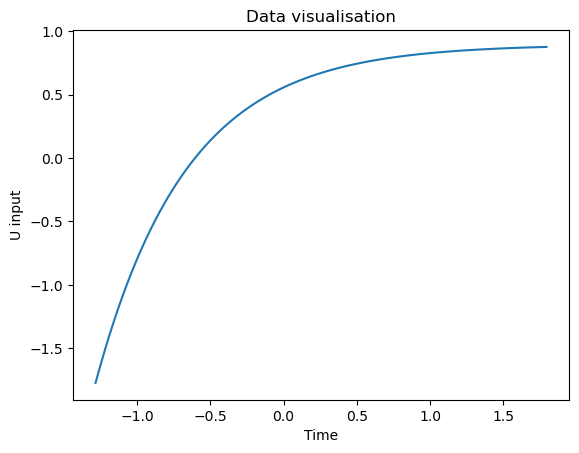

In [113]:

# Data normalisation
test_size = 120

X = df[["R", "C", "Time", "Vin"]].values[:test_size]
y = df[["Vout"]].values[:test_size]




scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_tensor = torch.tensor(scaler_X.fit_transform(X), dtype = torch.float32)
y_tensor = torch.tensor(scaler_y.fit_transform(y), dtype = torch.float32)


#print(X_tensor[:,0])
#print(Y_tensor)


print(X_tensor.shape, y_tensor.shape)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

plt.title("Data visualisation")
plt.plot(X_tensor[:, 2], y_tensor)
plt.xlabel('Time')
plt.ylabel('U input')

In [114]:
nb_neu = 128

class RegressionModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, nb_neu)
        self.fc2 = nn.Linear(nb_neu,nb_neu)
        self.fc3 = nn.Linear(nb_neu,nb_neu)
        self.fc4 = nn.Linear(nb_neu, out_features)
        


    def forward(self, x):
        #x = self.dropout(x)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)  # No activation on output for regression
        return x

In [115]:
in_features = 4
out_features = 1


model = RegressionModel(in_features, out_features)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)


## The differential equation that controls our physics loss 

## ⚙️ Differential Equation of an RC Circuit (Time Domain)

The first-order differential equation for the voltage across a capacitor in an RC circuit is:

$$
u(t) + RC \cdot \frac{du(t)}{dt} = U
$$

Where:
- \( u(t) \) is the output voltage (e.g. across the capacitor),
- \( R \) is the resistance (Ω),
- \( C \) is the capacitance (F),
- \( U \) is the constant input voltage.

This equation describes the dynamic response of the voltage in the circuit over time.


In [116]:
# Function to compute the PDE residual: 

def pde_residual(model,x):

    # Predict V_out from the model
    x = x.clone().detach().requires_grad_(True)
    """print(x.shape)"""
    V_out_pred = model(x)
    """print(V_out_pred.shape)"""

    R = x[:,0]
    C = x[:,1]
    t = x[:,2]
    Vin = x[:,3]

    """print(R.shape)
    print(C.shape)
    print(t.shape)
    print(Vin.shape)"""

    t.requires_grad_(True)

    # Compute dV_out/dt using autodiff
    dV_out_dt = (torch.autograd.grad(V_out_pred, x, grad_outputs=torch.ones_like(V_out_pred), create_graph=True)[0])[:,0]
    """print(dV_out_dt.shape)"""
    # Compute physics residual

    """print(R.shape, C.shape, Vin.shape, t.shape)"""

    residual = R * C * dV_out_dt + V_out_pred - Vin
    return residual


#pde_test = pde_residual(model, X_tensor)
#print(pde_test)

pde_residual(model, X_tensor)


tensor([[ 4.5902,  4.5441,  4.4979,  ..., -0.0271, -0.0271, -0.0271],
        [ 4.5896,  4.5435,  4.4973,  ..., -0.0277, -0.0277, -0.0277],
        [ 4.5890,  4.5429,  4.4967,  ..., -0.0283, -0.0283, -0.0283],
        ...,
        [ 4.2834,  4.2372,  4.1910,  ..., -0.3339, -0.3339, -0.3339],
        [ 4.2815,  4.2353,  4.1892,  ..., -0.3358, -0.3358, -0.3358],
        [ 4.2797,  4.2335,  4.1873,  ..., -0.3376, -0.3376, -0.3376]],
       grad_fn=<SubBackward0>)

Epoch [1], Loss: 1.391705990
Epoch [2], Loss: 0.604657471
Epoch [3], Loss: 0.845788717
Epoch [4], Loss: 0.558957398
Epoch [5], Loss: 0.079175927
Epoch [6], Loss: 0.181330010
Epoch [7], Loss: 0.269956827
Epoch [8], Loss: 0.140869319
Epoch [9], Loss: 0.228344098
Epoch [10], Loss: 0.149258867
Epoch [11], Loss: 0.157210648
Epoch [12], Loss: 0.233026400
Epoch [13], Loss: 0.231545642
Epoch [14], Loss: 0.216877609
Epoch [15], Loss: 0.212440252
Epoch [16], Loss: 0.264689952
Epoch [17], Loss: 0.203098089
Epoch [18], Loss: 0.218953773
Epoch [19], Loss: 0.227497116
Epoch [20], Loss: 0.173441470
Epoch [21], Loss: 0.095678531
Epoch [22], Loss: 0.071964547
Epoch [23], Loss: 0.241319984
Epoch [24], Loss: 0.129655868
Epoch [25], Loss: 0.127748340
Epoch [26], Loss: 0.146303579
Epoch [27], Loss: 0.123750478
Epoch [28], Loss: 0.204351425
Epoch [29], Loss: 0.197945803
Epoch [30], Loss: 0.187876135
Epoch [31], Loss: 0.110381499
Epoch [32], Loss: 0.130939767
Epoch [33], Loss: 0.111520872
Epoch [34], Loss: 0

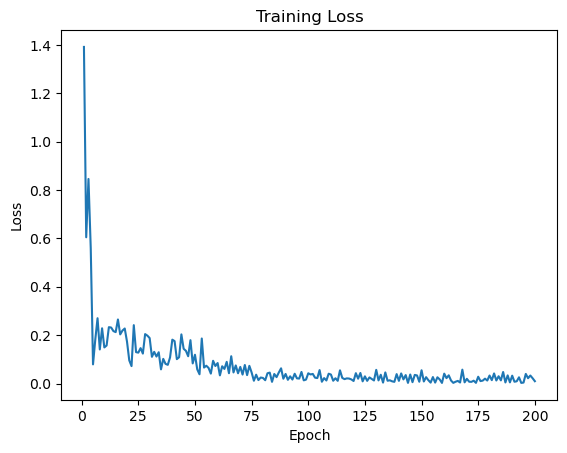

In [117]:
nb_epochs = 200
losses = []
epoch = [] 
# Before training
#set_seed(42)
model.train()
for i in range(nb_epochs):
    for X_batch, y_batch in dataloader:

        # Physics loss
        res = pde_residual(model, X_batch)
        loss_physics = torch.mean(res**2)

        # MSE loss
        outputs = model(X_batch)
        loss_mse = criterion(outputs, y_batch) 

        # final loss
        lamb = 0.01
        loss = loss_mse + lamb * loss_physics

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    epoch.append(i+1)
    print(f'Epoch [{i+1}], Loss: {loss.item():.9f}')

# Plot the loss curve
plt.plot(epoch, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
   

In [118]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model(X_tensor)  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion(predictions, y_tensor)
    print(f"Evaluation Loss: {loss.item():.3f}")

    predictions_original = scaler_y.inverse_transform(predictions.numpy())

    # Print the inverse transformed predictions
"""    print("Inverse Predictions: \n", predictions_original)"""

Evaluation Loss: 0.001


'    print("Inverse Predictions: \n", predictions_original)'

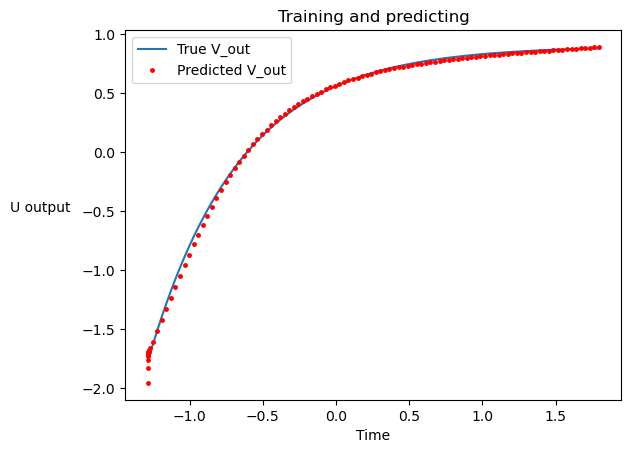

In [119]:
plt.title("Training and predicting")
plt.plot(X_tensor[:,2], y_tensor[:,0], label = "True V_out")
plt.xlabel("Time")
plt.ylabel("U output", rotation = 0, labelpad=30)
plt.plot(X_tensor[:,2], predictions[:,0], label = "Predicted V_out", color='red', linestyle='None', marker='.', markersize=5)
plt.legend()

plt.show()

In [120]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([128, 4])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([128, 128])
fc2.bias 	 torch.Size([128])
fc3.weight 	 torch.Size([128, 128])
fc3.bias 	 torch.Size([128])
fc4.weight 	 torch.Size([1, 128])
fc4.bias 	 torch.Size([1])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

Evaluation Loss: 0.001


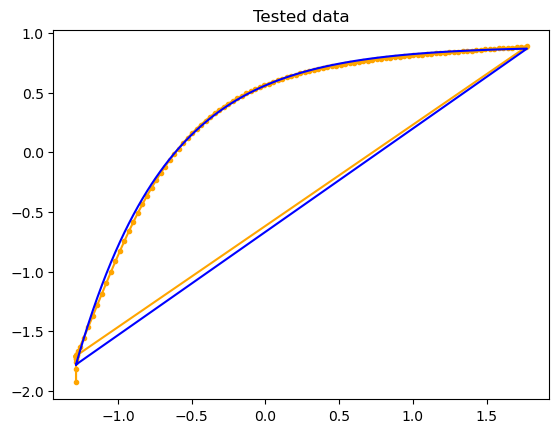

In [122]:
# Defining model name and save the model

name = "My_model"    # À changer selon l'utilisateur
torch.save(model.state_dict(), name)

# Load the saved model and evaluate

my_model = RegressionModel(in_features, out_features)
my_model.load_state_dict(torch.load(name, weights_only=True))
my_model.eval()


# Load new data 
start = 123
end = 245

X2 = df[["R", "C", "Time", "Vin"]].values[start : end]
y2 = df[["Vout"]].values[start : end]

scaler_X2 = StandardScaler()
scaler_y2 = StandardScaler()

X_tensor2 = torch.tensor(scaler_X2.fit_transform(X2), dtype = torch.float32)
y_tensor2 = torch.tensor(scaler_y2.fit_transform(y2), dtype = torch.float32)


with torch.no_grad():
    # Forward pass
    pred2 = my_model(X_tensor2)  

    # Calculate the loss (optional)
    loss = criterion(pred2, y_tensor2)
    print(f"Evaluation Loss: {loss.item():.3f}")

# Plot the tested data
plt.title("Tested data")
plt.plot(X_tensor2[:,2], pred2, label = 'predicted', marker = '.', color = 'orange')
plt.plot(X_tensor2[:,2], y_tensor2, label = 'true', color = 'blue')

#print(pred2)